In [16]:
import numpy as np
from optparse import OptionParser
import pickle
import re
from scipy.signal import hilbert
from scipy.signal import resample
import scipy.fftpack as fftp
import os
import process_func as prf
import importlib as imp
import matplotlib.pyplot as plt
import fluence as flu
import scipy.interpolate as intp
from matplotlib import cm


In [17]:
datadir='/Users/kmulrey/radio/viewer/data/272886233/1/coreas/proton/'

fileno='000091'

In [73]:
l_trace=4082
nantennas=160
   
onskypower=np.zeros([nantennas,2])
antenna_position=np.zeros([nantennas,3])
xyz_trace=np.zeros([nantennas,3,l_trace])

filteredpower=np.zeros([nantennas,2])
power=np.zeros([nantennas,2])
power11=np.zeros([nantennas,2])
power21=np.zeros([nantennas,2])
power41=np.zeros([nantennas,2])
peak_time=np.zeros([nantennas,2])
peak_bin=np.zeros([nantennas,2])
peak_amplitude=np.zeros([nantennas,2])
pol_angle=np.zeros([nantennas])
pol_angle_filt=np.zeros([nantennas])

fluence=np.zeros([nantennas])

   
longfile = '{0}/DAT{1}.long'.format(datadir,str(fileno).zfill(6))
steerfile = '{0}/steering/RUN{1}.inp'.format(datadir,str(fileno).zfill(6))
listfile = open('{0}/steering/SIM{1}.list'.format(datadir,str(fileno).zfill(6)))
lorafile = '{0}/DAT{1}.lora'.format(datadir,str(fileno).zfill(6))
longdata=np.genfromtxt(longfile, skip_header=2, skip_footer=5, usecols=(0,2,3))
xlength=np.argmax(np.isnan(longdata[:,0]))
Xground=xlength*10.0
profile = longdata[0:xlength,:]

# this reading longprofile is broken?
#longprofile=np.zeros([400,3]) #The profiles have different lengths, unlikely to exceed 400... (maybe inclined events??)
#longprofile[0:xlength,:]=np.array([profile[:,0],profile[:,1]+profile[:,2],profile[:,2]-profile[:,1]]).T

hillas = np.genfromtxt(re.findall("PARAMETERS.*",open(longfile,'r').read()))[2:]
zenith=(np.genfromtxt(re.findall("THETAP.*",open(steerfile,'r').read()))[1])*np.pi/180. #rad; CORSIKA coordinates
azimuth=np.mod(np.genfromtxt(re.findall("PHIP.*",open(steerfile,'r').read()))[1],360)*np.pi/180.  #rad; CORSIKA coordinates
energy=np.genfromtxt(re.findall("ERANGE.*",open(steerfile,'r').read()))[1] #GeV
lines = listfile.readlines()



In [19]:
imp.reload(prf)


<module 'process_func' from '/Users/kmulrey/radio/viewer/scripts/process_func.py'>

In [94]:
#for j in np.arange(nantennas):
for j in np.arange(20,21):

        antenna_position[j] = (lines[j].split(" ")[2:5]) #read antenna position...
        antenna_file = lines[j].split(" ")[5]   #... and output filename from the antenna list file
        coreasfile = '{0}/SIM{1}_coreas/raw_{2}.dat'.format(datadir,str(fileno).zfill(6),antenna_file[:-1]) #drop the \n from the string!
        data=np.genfromtxt(coreasfile)
        data[:,1:]*=2.99792458e4 # convert Ex, Ey and Ez (not time!) to Volt/meter
        dlength=int(data.shape[0])
        poldata=np.ndarray([dlength,2])
        poldata_filt=np.ndarray([dlength,2])

        az_rot=3*np.pi/2+azimuth    #conversion from CORSIKA coordinates to 0=east, pi/2=north
        zen_rot=zenith
        XYZ=np.zeros([dlength,3])
        XYZ[:,0]=-data[:,2] #conversion from CORSIKA coordinates to 0=east, pi/2=north
        XYZ[:,1]=data[:,1]
        XYZ[:,2]=data[:,3]
        
        # find value to roll
        t = np.argmax([np.max(abs(XYZ[:,0])),np.max(abs(XYZ[:,1])),np.max(abs(XYZ[:,2]))])
        roll_n=int(len(XYZ[:,t])/2-np.argmax(abs(XYZ[:,t])))

        
        xyz_trace[j,0]=np.roll(XYZ[:,0],roll_n)
        xyz_trace[j,1]=np.roll(XYZ[:,1],roll_n)
        xyz_trace[j,2]=np.roll(XYZ[:,2],roll_n)


        
        #UVW=prf.GetUVW(XYZ,0,0,0,zen_rot,az_rot,1.1837)#1.1837)
        UVW=prf.GetUVW(xyz_trace[j].T,0,0,0,zen_rot,az_rot,1.1837)#1.1837)

        Stokes=prf.stokes_parameters(UVW[:,0],UVW[:,1],fftp.hilbert(UVW[:,0]),fftp.hilbert(UVW[:,1]))
        pol_angle[j]=prf.polarization_angle(Stokes)
        UVWfilt=prf.FreqFilter(UVW,30,80,data[1,0]-data[0,0])
        Stokesfilt=prf.stokes_parameters(UVWfilt[:,0],UVWfilt[:,1],fftp.hilbert(UVWfilt[:,0]),fftp.hilbert(UVWfilt[:,1]))
        pol_angle_filt[j]=prf.polarization_angle(Stokesfilt)
        # Convert to on-sky coordinates (n, theta, phi) to prepare for application of antenna model
        #poldata[:,0] = -1.0/np.sin(zen_rot)*data[:,3] # -1/sin(theta) *z
        #poldata[:,1] = np.sin(az_rot)*data[:,2] + np.cos(az_rot)*data[:,1] # -sin(phi) *x + cos(phi)*y in coREAS 0=positive y, 1=negative x
        
        
        poldata[:,0] = -1.0/np.sin(zen_rot)*xyz_trace[j,2] # -1/sin(theta) *z
        poldata[:,1] = -1*np.sin(az_rot)*xyz_trace[j,0] + np.cos(az_rot)*xyz_trace[j,1] # -sin(phi) *x + cos(phi)*y in coREAS 0=positive y, 1=negative x
        
        
        
        
        
        pol0fft=np.fft.rfft(poldata.T[0])
        pol1fft=np.fft.rfft(poldata.T[1])
        freq = np.fft.rfftfreq(len(poldata), d=data[1,0]-data[0,0])
        # if you want to change frequency band, change the frequencies here
        bandpass_filter = prf.simple_bandpass(freq,lower_freq=30.0E6, upper_freq=80.0E6)
        pol0fft_filt=pol0fft*bandpass_filter
        pol1fft_filt=pol1fft*bandpass_filter
        poldata_filt.T[0]=np.fft.irfft(pol0fft_filt)
        poldata_filt.T[1]=np.fft.irfft(pol1fft_filt)
        
        hold=flu.calculate_energy_fluence_vector(poldata_filt,data.T[0], signal_window=100., remove_noise=True)
        fluence[j]=hold[0]+hold[1]

        

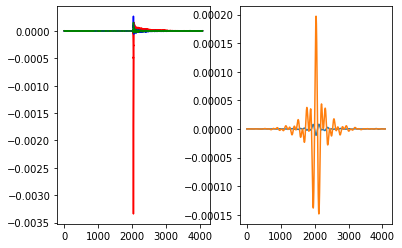

In [95]:
fig = plt.figure(facecolor='white')
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(xyz_trace[20][0],color='red')
ax1.plot(xyz_trace[20][1],color='blue')
ax1.plot(xyz_trace[20][2],color='green')

ax2.plot(poldata_filt.T[0])
ax2.plot(poldata_filt.T[1])

In [21]:
#put everything in the right coordinate system for the transformation to shower plane

az=azimuth+3*np.pi/2 #  +x = east (phi=0), +y = north (phi=90)

zen=zenith
temp=np.copy(antenna_position)
antenna_position[:,0], antenna_position[:,1], antenna_position[:,2] = -temp[:,1]/100., temp[:,0]/100., temp[:,2]/100.

In [22]:
# function takes antenna positions in the ground plane and returns positions in the shower plane

def GetUVW(pos, cx, cy, zen, az):
    #relpos = pos-np.array([cx,cy,2400])
    relpos = pos-np.array([cx,cy,0])
    #inc=-1.48#-84.8/180.*np.pi#1.1837
    inc=1.1837#-84.8/180.*np.pi#1.1837

    B = np.array([0,np.cos(inc),-np.sin(inc)])
    v = np.array([-np.cos(az)*np.sin(zen),-np.sin(az)*np.sin(zen),-np.cos(zen)])
    #print v
    vxB = np.array([v[1]*B[2]-v[2]*B[1],v[2]*B[0]-v[0]*B[2],v[0]*B[1]-v[1]*B[0]])
    vxB = vxB/np.linalg.norm(vxB)
    vxvxB = np.array([v[1]*vxB[2]-v[2]*vxB[1],v[2]*vxB[0]-v[0]*vxB[2],v[0]*vxB[1]-v[1]*vxB[0]])
    return np.array([np.inner(vxB,relpos),np.inner(vxvxB,relpos),np.inner(v,relpos)]).T

In [23]:
# transform simulated antenna positions to shower plane (vxB, vxvxB)
antUVW=GetUVW(antenna_position, 0, 0, zen, az)

In [24]:
#interpolation
rbf = intp.Rbf(antUVW.T[0], antUVW.T[1], fluence,smooth =0,function='quintic')
#rbf = intp.Rbf(antenna_position.T[0],antenna_position.T[1], fluence,smooth =0,function='quintic')


In [25]:
#make the grid to plot
dist_scale=500
ti = np.linspace(-dist_scale, dist_scale, 150)
XI, YI = np.meshgrid(ti, ti)
ZI = rbf(XI, YI)


/var/folders/80/rtt8wgyj27v6g316xvh03yyc0000gn/T/ipykernel_10061/2436825790.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax2.pcolor(XI, YI, ZI,vmax=np.max(fluence), vmin=0,cmap=cm.jet)


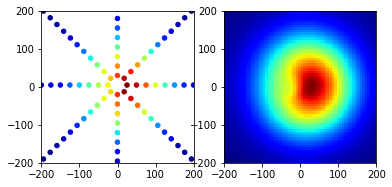

In [26]:
fig = plt.figure(facecolor='white')
ax1 = fig.add_subplot(1,2,1,aspect=1)
ax2 = fig.add_subplot(1,2,2,aspect=1)

ax2.pcolor(XI, YI, ZI,vmax=np.max(fluence), vmin=0,cmap=cm.jet)
#ax2.pcolor(XI, YI, ZI,vmax=70, vmin=0,cmap=cm.jet)

ax1.scatter(antUVW.T[0],antUVW.T[1],20,c=fluence,vmax=np.max(fluence), vmin=0,cmap=cm.jet)
#ax1.scatter(antenna_position.T[0],antenna_position.T[1],20,c=fluence,vmax=np.max(fluence), vmin=0,cmap=cm.jet)
#ax1.scatter(antenna_position.T[0],antenna_position.T[1],20,c=fluence,vmax=70, vmin=0,cmap=cm.jet)

ax1.set_xlim([-200,200])
ax1.set_ylim([-200,200])
ax2.set_xlim([-200,200])
ax2.set_ylim([-200,200])

#ax1.set_title('ground plane')
#ax2.set_title('interpolated- shower plane')


plt.show()

In [27]:
print(np.max(fluence))

12.734886947721076


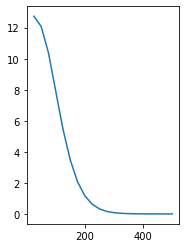

In [30]:
fig = plt.figure(facecolor='white')
ax1 = fig.add_subplot(1,2,1)
arm=0

#ax1.scatter(antUVW.T[0][arm::8],antUVW.T[1][arm::8],20,c=fluence[arm::8],vmax=80, vmin=0,cmap=cm.jet)
#ax1.scatter(antenna_position.T[0],antenna_position.T[1],20,c=fluence,vmax=np.max(fluence), vmin=0,cmap=cm.jet)
#ax1.scatter(antenna_position.T[0],antenna_position.T[1],20,c=fluence,vmax=70, vmin=0,cmap=cm.jet)


ax1.plot(antUVW.T[0][arm::8],fluence[arm::8])


#ax1.set_xlim([-400,400])

#ax1.set_title('ground plane')


plt.show()